<a href="https://colab.research.google.com/github/ryota0051/nishika_pcb/blob/main/experiments/01_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 半導体コンペチュートリアル
コンペティションではプリント基板（PCB）の画像から、コンデンサや抵抗といった部品（SMD）の位置を推定します。
このノートブックでは、プリント基板についての簡単な説明及びチュートリアルベースラインを紹介します。

# ライブラリのインポートと設定
はじめに、ライブラリのインポートや設定を行います。なお、本ノートブックでは以下のディレクトリ構成を想定しています。

ベースのパスはチュートリアル動作確認後、変更する
```
/content/drive/MyDrive/nishika_pcb/: ベースとなる作業ディレクトリ
┣ input: 本コンペで提供されているデータを格納するディレクトリ
┃ ┣ train_imgs.zip: 学習データの画像が格納されたzipファイル
┃ ┣ test_imgs.zip: テストデータの画像が格納されたzipファイル
┃ ┣ train.csv: 訓練用データ
┃ ┣ test.csv: 評価用データ
┃ ┗ sample_submission.csv: 提出用データのサンプル
┣ notebook: notebookを格納するディレクトリ
┗ output: 本コンペで提出するファイルを格納するディレクトリ
```

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nvidia-smi

Sat Mar 18 09:45:47 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P0    28W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
from glob import glob

from matplotlib import pyplot as plt
from IPython.display import clear_output
from PIL import Image
import cv2

import os, random, gc
import re, time, json
import collections
from  ast import literal_eval
import ast

from tqdm.notebook import tqdm
import joblib

from sklearn.metrics import label_ranking_average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection  import StratifiedKFold
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder

import torch
from torch import nn, optim
from  torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.transforms import ToPILImage
from torchvision.transforms import functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

In [ ]:
!ls "/content/drive/MyDrive/pcb"

01_tutorial.ipynb  input  output


In [ ]:
DATA_ROOT = Path("/content/drive/MyDrive/pcb")
INPUT = DATA_ROOT / "input"
OUTPUT = DATA_ROOT / "output"
OUTPUT.mkdir(exist_ok=True, parents=True)

In [ ]:
def fix_all_seeds(seed):
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
fix_all_seeds(2021)

画像ファイルはzipファイルになっているため、解凍を行います。また、ドライブ経由だと処理が遅くなるため、画像ファイルはランタイム配下にコピーします。

In [ ]:
!cp -r "/content/drive/MyDrive/pcb/input/train_imgs.zip" .
!cp -r "/content/drive/MyDrive/pcb/input/test_imgs.zip" .

In [ ]:
# ファイルの解凍
!unzip "/content/train_imgs.zip"
!unzip "/content/test_imgs.zip"

Archive:  /content/train_imgs.zip
   creating: train_imgs/
  inflating: train_imgs/pcb_6b_cc_5.png  
  inflating: train_imgs/pcb_10b_cc_8.png  
  inflating: train_imgs/pcb_10f_cc_2.png  
  inflating: train_imgs/pcb_10f_cc_3.png  
  inflating: train_imgs/pcb_21f_cc_12.png  
  inflating: train_imgs/pcb_10b_cc_9.png  
  inflating: train_imgs/pcb_6b_cc_4.png  
  inflating: train_imgs/pcb_6b_cc_6.png  
  inflating: train_imgs/pcb_1f_cc_10.png  
  inflating: train_imgs/pcb_16f_cc_11.png  
  inflating: train_imgs/pcb_6b_cc_7.png  
  inflating: train_imgs/pcb_17b_cc_11.png  
  inflating: train_imgs/pcb_6f_cc_9.png  
  inflating: train_imgs/pcb_8b_cc_8.png  
  inflating: train_imgs/pcb_6b_cc_3.png  
  inflating: train_imgs/pcb_10f_cc_4.png  
  inflating: train_imgs/pcb_43f_cc_14.png  
  inflating: train_imgs/pcb_10f_cc_5.png  
  inflating: train_imgs/pcb_4f_cc_10.png  
  inflating: train_imgs/pcb_6b_cc_2.png  
  inflating: train_imgs/pcb_13f_cc_11.png  
  inflating: train_imgs/pcb_8b_cc_9.png  

# Config

In [ ]:
TRAIN_PATH = Path("/content/train_imgs")
TEST_PATH = Path("/content/test_imgs")

# リサイズ時の幅と大きさ
WIDTH = 500
HEIGHT = 300

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

RESNET_MEAN = (0.485, 0.456, 0.406)
RESNET_STD = (0.229, 0.224, 0.225)

BATCH_SIZE = 1

MOMENTUM = 0.9
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0005

# 勾配累積
ACCUM_ITER = 2

# マスクを残す閾値
MASK_THRESHOLD = 0.5

# 正規化するかどうか
NORMALIZE = False

# スケジューラ
USE_SCHEDULER = False

# エポック数
NUM_EPOCHS = 5

# 1画像で発見する最大のボックス数
BOX_DETECTIONS_PER_IMG = 500

MIN_SCORE = 0.60

# データの確認
はじめにデータの確認を行います。

In [ ]:
train = pd.read_csv(INPUT / "train.csv")
train

Instance ID              image filename_index  height  width  \
0                0  pcb_32b_cc_12.png        pcb_32b    5474   6783   
1                1  pcb_32b_cc_12.png        pcb_32b    5474   6783   
2                2  pcb_32b_cc_12.png        pcb_32b    5474   6783   
3                3  pcb_32b_cc_12.png        pcb_32b    5474   6783   
4                4  pcb_32b_cc_12.png        pcb_32b    5474   6783   
...            ...                ...            ...     ...    ...   
25698          859  pcb_51b_cc_31.png        pcb_51b    5504   8256   
25699          860  pcb_51b_cc_31.png        pcb_51b    5504   8256   
25700          861  pcb_51b_cc_31.png        pcb_51b    5504   8256   
25701          862  pcb_51b_cc_31.png        pcb_51b    5504   8256   
25702          822  pcb_51b_cc_31.png        pcb_51b    5504   8256   

                                                Vertices  \
0      [[[698, 4511], [698, 4436], [700, 4434], [702,...   
1      [[[241, 4507], [240, 4508], [240, 4535], [239,...   
2      [[[545, 3351], [547, 3351], [548, 3349], [548,...   
3      [[[281, 3410], [329, 3409], [331, 3408], [332,...   
4      [[[392, 3562], [384, 3563], [383, 3562], [383,...   
...                                                  ...   
25698  [[[3824, 1798], [3823, 1799], [3821, 1799], [3...   
25699  [[[3730, 1799], [3738, 1799], [3740, 1799], [3...   
25700  [[[5739, 353], [5740, 353], [5749, 353], [5751...   
25701  [[[3640, 2536], [3640, 2553], [3649, 2553], [3...   
25702  [[[4585, 1994], [4647, 1994], [4649, 1994], [4...   

                                                     rle  
0      30062961 47 30069742 50 30076523 53 30083305 5...  
1      30571223 31 30578005 32 30584788 32 30591571 3...  
2      22506489 15 22513271 42 22520054 55 22526837 5...  
3      22913254 52 22920035 55 22926817 57 22933600 5...  
4      23415311 59 23422094 60 23428877 60 23435660 6...  
...                                                  ...  
25698  14848113 12 14856366 16 14864622 16 14872878 1...  
25699  14856274 12 14864528 15 14872784 15 14881040 1...  
25700  2920108 13 2928364 14 2936619 15 2944875 15 29...  
25701  20940857 10 20949113 10 20957369 10 20965625 1...  
25702  16467050 65 16475303 69 16483559 70 16491815 7...  

[25703 rows x 7 columns]

In [ ]:
test = pd.read_csv(INPUT/"test.csv")
test

image  height  width
0   pcb_49f_cc_26.png    4159   6676
1     pcb_9b_cc_8.png    6781   5501
2   pcb_25f_cc_11.png    5460   6100
3   pcb_48f_cc_26.png    5432   6649
4   pcb_31f_cc_19.png    4109   7676
5   pcb_35f_cc_11.png    4565   4875
6   pcb_47b_cc_25.png    4720   8021
7   pcb_19f_cc_12.png    5226   7990
8   pcb_15f_cc_11.png    3783   5504
9   pcb_40f_cc_21.png    5296   7144
10  pcb_51f_cc_30.png    5573   8155
11  pcb_11f_cc_11.png    3155   4420
12  pcb_46f_cc_23.png    2801   3364
13  pcb_41b_cc_15.png    3328   7367
14    pcb_5f_cc_3.png    3092   3919
15    pcb_8f_cc_9.png    4738   7999
16    pcb_7b_cc_3.png    3897   4745
17    pcb_3f_cc_7.png    3033   2701
18  pcb_30b_cc_11.png    2105   4058
19  pcb_30f_cc_11.png    2147   3895
20  pcb_37f_cc_11.png    4402   4985
21  pcb_26f_cc_11.png    4328   4436
22  pcb_39f_cc_13.png    3928   6104
23  pcb_12f_cc_11.png    3671   4429
24  pcb_49b_cc_31.png    2719   4526
25  pcb_14f_cc_11.png    1957   7566
26   pcb_0f_cc_11.png    3030   4728
27  pcb_46b_cc_23.png    2659   3176

各カラムの説明は以下となります。

- Instance ID:画像ごとのアノテーション番号
- image：画像ファイル名
- filename_index:同じ画像を判断するための名前（以下のコードを参照）
- Vertices:部品位置を表したアノテーション
- rle:部品位置を表したアノテーション（提出形式に沿ったもの）
- filename:画像ファイル名から.pngを抜いたもの
- height:画像の高さ
- width:画像の幅

今回予測すべきものはrleになりますが、verticesはrleで表す領域を頂点集合を使って表したものです。

In [ ]:
# train/testで画像の重複はありません
len(set(train["image"].unique()) & set(test["image"].unique()))

0

In [ ]:
# 訓練データの画像数は122、テストデータの画像数は28です
print("訓練画像数", train["image"].nunique())
print("テスト画像数", test["image"].nunique())

訓練画像数 122
テスト画像数 28


In [ ]:
# 訓練データにおける1枚の画像についているアノテーション数は最大で1028個です
train["Instance ID"].max()

1028

# 画像の選定
以下では、アノテーション数が非常に多い画像（500以上）を学習データからのぞいています。これは、google colabの無料版ではアノテーション数が非常に多い画像はGPUのメモリに載せることができないからです。

アノテーションが多い画像も学習に利用したい場合は、よりメモリの大きなGPUを使用する必要があります。

In [ ]:
# 各画像のアノテーション数をカウント
annotation_df = train.groupby('image')['Instance ID'].max().reset_index()

In [ ]:
# アノテーション数が500を超える画像のファイル名を取得
remove_imgname = annotation_df[annotation_df['Instance ID'] >= 500]['image'].tolist()

In [ ]:
# remove_imgnameに含まれない画像のデータのみを取得
train = train[~train['image'].isin(remove_imgname)].reset_index(drop = True)

In [ ]:
train

Instance ID              image filename_index  height  width  \
0                0  pcb_32b_cc_12.png        pcb_32b    5474   6783   
1                1  pcb_32b_cc_12.png        pcb_32b    5474   6783   
2                2  pcb_32b_cc_12.png        pcb_32b    5474   6783   
3                3  pcb_32b_cc_12.png        pcb_32b    5474   6783   
4                4  pcb_32b_cc_12.png        pcb_32b    5474   6783   
...            ...                ...            ...     ...    ...   
18848          265  pcb_20b_cc_17.png        pcb_20b    2600   7632   
18849          266  pcb_20b_cc_17.png        pcb_20b    2600   7632   
18850          267  pcb_20b_cc_17.png        pcb_20b    2600   7632   
18851          268  pcb_20b_cc_17.png        pcb_20b    2600   7632   
18852          269  pcb_20b_cc_17.png        pcb_20b    2600   7632   

                                                Vertices  \
0      [[[698, 4511], [698, 4436], [700, 4434], [702,...   
1      [[[241, 4507], [240, 4508], [240, 4535], [239,...   
2      [[[545, 3351], [547, 3351], [548, 3349], [548,...   
3      [[[281, 3410], [329, 3409], [331, 3408], [332,...   
4      [[[392, 3562], [384, 3563], [383, 3562], [383,...   
...                                                  ...   
18848  [[[6976, 976], [6980, 974], [6986, 975], [6991...   
18849  [[[6988, 894], [7039, 894], [7047, 895], [7054...   
18850  [[[6988, 816], [7038, 816], [7041, 814], [7050...   
18851  [[[6986, 735], [7038, 735], [7042, 733], [7053...   
18852  [[[2396, 737], [2388, 737], [2384, 743], [2383...   

                                                     rle  
0      30062961 47 30069742 50 30076523 53 30083305 5...  
1      30571223 31 30578005 32 30584788 32 30591571 3...  
2      22506489 15 22513271 42 22520054 55 22526837 5...  
3      22913254 52 22920035 55 22926817 57 22933600 5...  
4      23415311 59 23422094 60 23428877 60 23435660 6...  
...                                                  ...  
18848  7440549 4 7440613 9 7448179 77 7455809 80 7463...  
18849  6822357 7 6829983 70 6837614 82 6845245 84 685...  
18850  6211863 5 6219429 6 6219490 12 6227058 3 62270...  
18851  5601299 12 5608864 6 5608929 15 5616494 83 562...  
18852  5619553 6 5627173 24 5634804 28 5642436 29 565...  

[18853 rows x 7 columns]

# データの可視化
ここでは訓練データの1つを確認してみましょう。

In [ ]:
def read_img(path):
    data = cv2.imread(str(path))
    
    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
    return data

In [ ]:
def plot_img_allanotation(img_name):
    # 1つの画像のアノテーションをまとめて描画
    target_df = train[train["image"] == img_name].reset_index(drop=True)

    print("画像ファイル名 ---> ", img_name)
    print("アノテーション数 ---> ", len(target_df))

    # 画像のパス
    path = TRAIN_PATH / img_name

    # 画像を小さくする倍率
    scale = 5

    img = read_img(path)
    img = cv2.resize(img, None, fx=1/scale, fy=1/scale)

    # 1枚の画像全てのアノテーションをまとめる
    start = 0
    end = len(target_df)

    all_ano = []
    for i in range(start, end, 1):
        s = target_df["Vertices"].iloc[i]
        ano = ast.literal_eval(s)
        points = np.array(ano)
        points = (points / scale).astype(int)
        all_ano.append(points)

    # アノテーションの追加
    cv2.polylines(img, all_ano, isClosed=True, color=(0, 0, 255), thickness=1)

    fig = plt.figure(dpi=150)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

画像ファイル名 --->  pcb_32b_cc_12.png
アノテーション数 --->  284


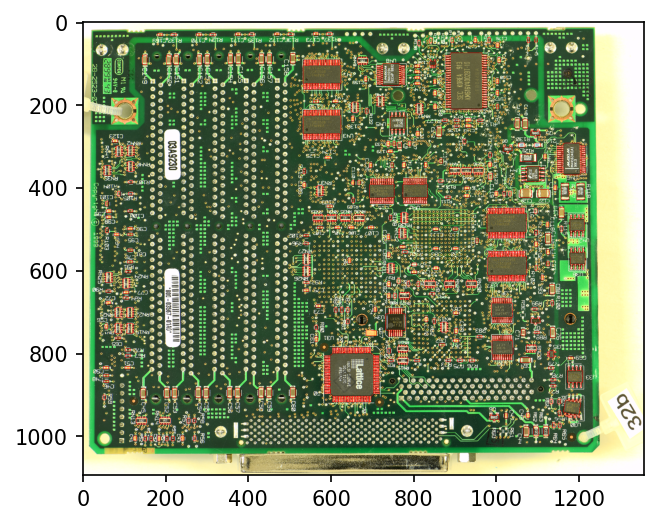

In [ ]:
target_img = train["image"].unique()[0]
plot_img_allanotation(target_img)

コンデンサーやチップの部分に赤い線が入っていることがわかります。

なお、今回のデータセットで注意すべき点として、画像の重複が挙げられます。filename_indexが同一であるものでも、画像ファイル名が異なるものがあり、これらは撮影時の大きさが異なったり、色のフィルターがかかっているものとなります。

pcb_9f


  0%|          | 0/9 [00:00<?, ?it/s]

画像ファイル名 --->  pcb_9f_cc_5.png
アノテーション数 --->  121


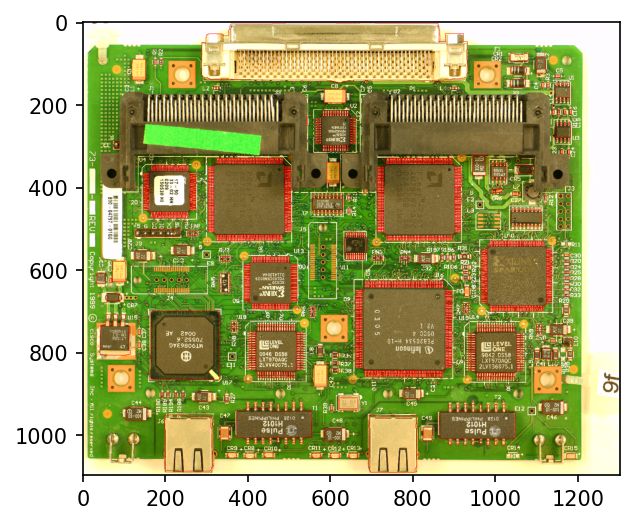

画像ファイル名 --->  pcb_9f_cc_4.png
アノテーション数 --->  120


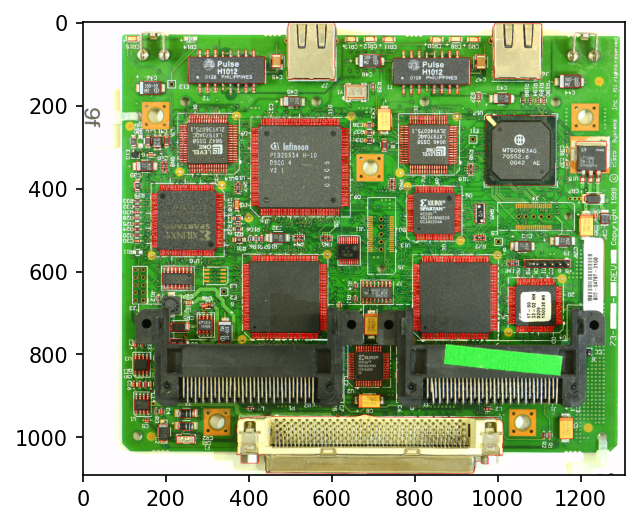

画像ファイル名 --->  pcb_9f_cc_6.png
アノテーション数 --->  122


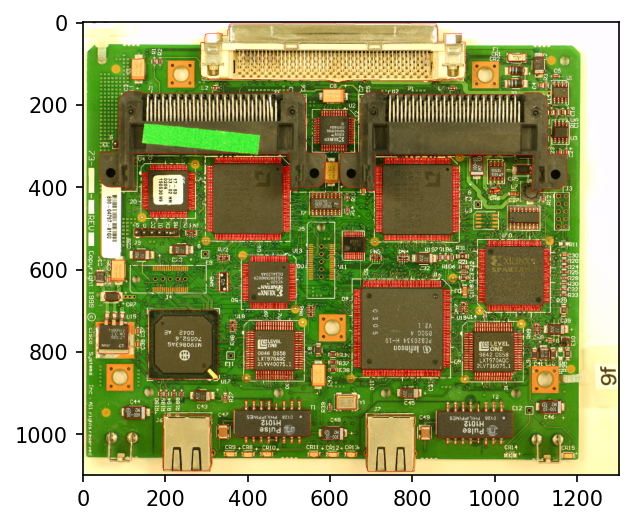

画像ファイル名 --->  pcb_9f_cc_7.png
アノテーション数 --->  122


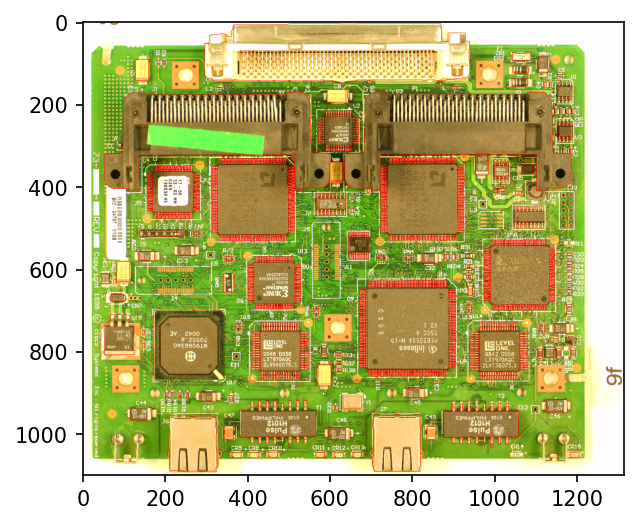

画像ファイル名 --->  pcb_9f_cc_2.png
アノテーション数 --->  124


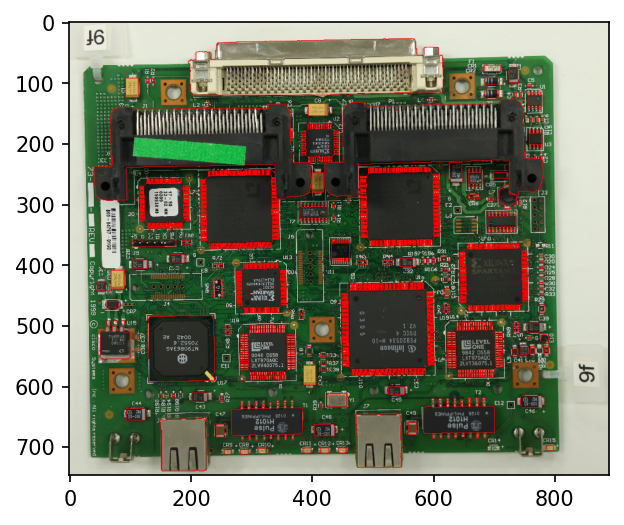

画像ファイル名 --->  pcb_9f_cc_3.png
アノテーション数 --->  121


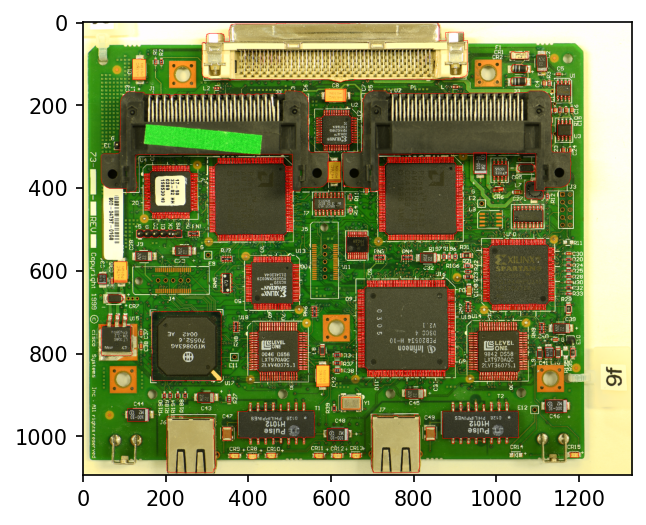

画像ファイル名 --->  pcb_9f_cc_10.png
アノテーション数 --->  125


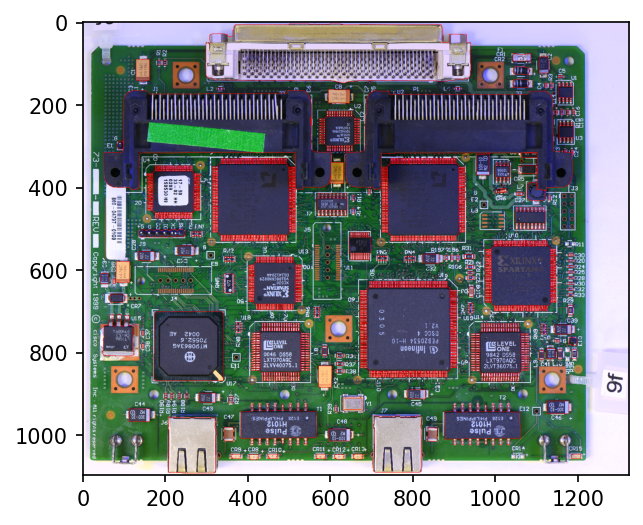

画像ファイル名 --->  pcb_9f_cc_8.png
アノテーション数 --->  120


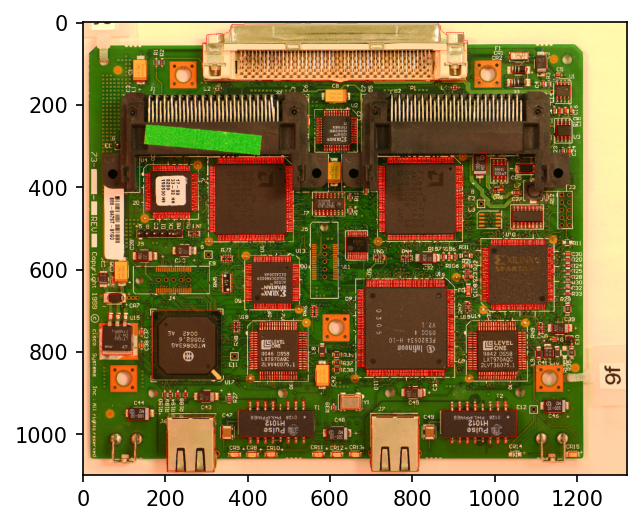

画像ファイル名 --->  pcb_9f_cc_9.png
アノテーション数 --->  123


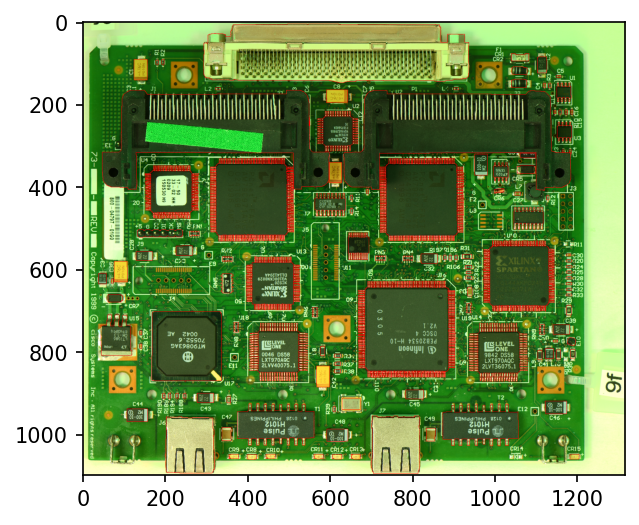

In [ ]:
file_unique = train["filename_index"].unique()[1]
print(file_unique)

img_gr_filenames = train[train["image"].str.contains(file_unique)]["image"].unique()

# 各画像をアノテーション付きで表示
for filename in tqdm(img_gr_filenames):
    plot_img_allanotation(filename)

同じ画像は最大で9枚含まれていることがわかります。なお、testには画像の重複はありません。

In [ ]:
# filename_indexごとに何枚の画像があるか
train.groupby("filename_index")["image"].nunique().sort_values(ascending=False)

filename_index
pcb_10b    9
pcb_1f     9
pcb_8b     9
pcb_7f     9
pcb_6b     9
pcb_4f     9
pcb_10f    9
pcb_9f     9
pcb_2f     7
pcb_3b     2
pcb_15b    2
pcb_18f    1
pcb_43f    1
pcb_41f    1
pcb_42b    1
pcb_42f    1
pcb_43b    1
pcb_44f    1
pcb_36f    1
pcb_47f    1
pcb_50b    1
pcb_50f    1
pcb_14b    1
pcb_13f    1
pcb_13b    1
pcb_39b    1
pcb_34f    1
pcb_16f    1
pcb_34b    1
pcb_33f    1
pcb_32f    1
pcb_16b    1
pcb_31b    1
pcb_29f    1
pcb_28f    1
pcb_27f    1
pcb_24f    1
pcb_23f    1
pcb_22f    1
pcb_21f    1
pcb_20f    1
pcb_20b    1
pcb_32b    1
Name: image, dtype: int64

# Dataset
続いて、データセットの作成を行います。

In [ ]:
class Compose:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target

# 垂直方向への反転
class VerticalFlip:
    def __init__(self, prob):
        self.prob = prob

    def __call__(self, image, target):
        if random.random() < self.prob:
            height, width = image.shape[-2:]
            image = image.flip(-2)
            bbox = target["boxes"]
            bbox[:, [1, 3]] = height - bbox[:, [3, 1]]
            target["boxes"] = bbox
            target["masks"] = target["masks"].flip(-2)
        return image, target

# 水平方向への反転
class HorizontalFlip:
    def __init__(self, prob):
        self.prob = prob

    def __call__(self, image, target):
        if random.random() < self.prob:
            height, width = image.shape[-2:]
            image = image.flip(-1)
            bbox = target["boxes"]
            bbox[:, [0, 2]] = width - bbox[:, [2, 0]]
            target["boxes"] = bbox
            target["masks"] = target["masks"].flip(-1)
        return image, target

# 正規化
class Normalize:
    def __call__(self, image, target):
        image = F.normalize(image, RESNET_MEAN, RESNET_STD)
        return image, target

class ToTensor:
    def __call__(self, image, target):
        image = F.to_tensor(image)
        return image, target
    

def get_transform(train):
    transforms = [ToTensor()]
    if NORMALIZE:
        transforms.append(Normalize())

    # オーグメンテーション
    if train: 
        transforms.append(HorizontalFlip(0.5))
        transforms.append(VerticalFlip(0.5))

    return Compose(transforms)

In [ ]:
def rle_decode(mask_rle, shape, color=1):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.float32)
    for lo, hi in zip(starts, ends):
        img[lo : hi] = color
    return img.reshape(shape)

In [ ]:
class SemiDataset(Dataset):
    def __init__(self, image_dir, df, transforms=None, resize=False):
        self.transforms = transforms
        self.image_dir = image_dir
        self.df = df

        # リサイズ
        self.should_resize = resize is not False
        if self.should_resize:
            self.height = int(HEIGHT * resize)
            self.width = int(WIDTH * resize)
        else:
            self.height = HEIGHT
            self.width = WIDTH
        
        self.image_info = collections.defaultdict(dict)
        temp_df = self.df.groupby('image')['rle'].agg(lambda x: list(x)).reset_index()
        temp_df = temp_df.merge(train[["image","height", "width"]].drop_duplicates(), on="image", how="inner").reset_index(drop=True)
        for index, row in temp_df.iterrows():
            self.image_info[index] = {
                    'image_id': row['image'],
                    'path': self.image_dir / row['image'],
                    'annotations': row["rle"],
                    'height': row["height"],
                    'width': row["width"]
                    }
    
    def get_box(self, a_mask):
        ''' 与えられたマスクのバウンディングボックスを取得 '''
        pos = np.where(a_mask)
        xmin = np.min(pos[1])
        xmax = np.max(pos[1])
        ymin = np.min(pos[0])
        ymax = np.max(pos[0])
        return [xmin, ymin, xmax, ymax]

    def __getitem__(self, idx):
        ''' 画像とターゲットを取得する '''

        # 画像の読み込み
        img_path = self.image_info[idx]["path"]
        img = Image.open(img_path).convert("RGB")

        # 読み込んだ画像をリサイズ
        if self.should_resize:
            img = img.resize((self.width, self.height), resample=Image.BILINEAR)

        # アノテーションや高さ・幅の情報を取得
        info = self.image_info[idx]

        # アノテーションの数
        n_objects = len(info['annotations'])
        # mask作る
        masks = np.zeros((len(info['annotations']), self.height, self.width), dtype=np.uint8)
        boxes = []

        for i, annotation in enumerate(info['annotations']):
            # rleをmaskに変更
            a_mask = rle_decode(annotation, (info['height'], info['width']))
            a_mask = Image.fromarray(a_mask)
            
            # maskもリサイズ
            if self.should_resize:
                a_mask = a_mask.resize((self.width, self.height), resample=Image.BILINEAR)
            
            a_mask = np.array(a_mask) > 0
            masks[i, :, :] = a_mask
            
            boxes.append(self.get_box(a_mask))

        # ラベルは1種類
        labels = [1 for _ in range(n_objects)]
        
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((n_objects,), dtype=torch.int64)

        # 今回使用するMask R-CNNで求められるデータをまとめる
        target = {
            'boxes': boxes,
            'labels': labels,
            'masks': masks,
            'image_id': image_id,
            'area': area,
            'iscrowd': iscrowd
        }

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.image_info)

In [ ]:
ds_train = SemiDataset(TRAIN_PATH, train, resize=True, transforms=get_transform(train=True))
dl_train = DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True, 
                      num_workers=2, collate_fn=lambda x: tuple(zip(*x)))

In [ ]:
sample = ds_train[0]

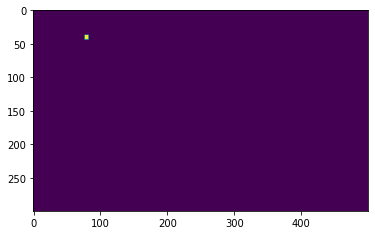

In [ ]:
plt.imshow(sample[1]['masks'][1])

# Training Model

続いて、モデルの構築に移ります。

今回は、mask-cnnと呼ばれる手法を採用します。

参考：

1. https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html
2. https://arxiv.org/abs/1703.06870

In [ ]:
def get_model():
    # クラス数：半導体（検出したいもの）+背景
    NUM_CLASSES = 2
    
    if NORMALIZE:
        model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True, 
                                                                   box_detections_per_img=BOX_DETECTIONS_PER_IMG,
                                                                   image_mean=RESNET_MEAN, 
                                                                   image_std=RESNET_STD)
    else:
        model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True,
                                                                  box_detections_per_img=BOX_DETECTIONS_PER_IMG)

    # 分類用のinput feature数
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # headの付け替え
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, NUM_CLASSES)

    # 物体検出用のinput feature数
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # headの付け替え
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, NUM_CLASSES)
    return model

model = get_model()
model.to(DEVICE)

for param in model.parameters():
    param.requires_grad = True
    
model.train();

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


  0%|          | 0.00/170M [00:00<?, ?B/s]

# Training Loop
modelまで定義ができたので、実際に学習を行います。

In [ ]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

n_batches = len(dl_train)

for epoch in range(1, NUM_EPOCHS + 1):
    print(f"Starting epoch {epoch} of {NUM_EPOCHS}")
    
    time_start = time.time()
    loss_accum = 0.0
    loss_mask_accum = 0.0
    
    for batch_idx, (images, targets) in tqdm(enumerate(dl_train, 1), total = len(dl_train)):

        # 入力および損失計算
        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())
        
        # backward
        loss.backward()

        # gradient accumulation
        if batch_idx % ACCUM_ITER == 0:
            optimizer.step()
            optimizer.zero_grad()
        
        # log
        loss_mask = loss_dict['loss_mask'].item()
        loss_accum += loss.item()
        loss_mask_accum += loss_mask
        
        if batch_idx % 4 == 0:
            print(f"    [Batch {batch_idx:3d} / {n_batches:3d}] Batch train loss: {loss.item():7.3f}. Mask-only loss: {loss_mask:7.3f}")
    
    if USE_SCHEDULER:
        lr_scheduler.step()
    
    # 損失
    train_loss = loss_accum / n_batches
    train_loss_mask = loss_mask_accum / n_batches

    elapsed = time.time() - time_start
    
    modeldir = str(OUTPUT/f"pytorch_model-e{epoch}.bin")
    torch.save(model.state_dict(), modeldir)
    prefix = f"[Epoch {epoch:2d} / {NUM_EPOCHS:2d}]"
    print(f"{prefix} Train mask-only loss: {train_loss_mask:7.3f}")
    print(f"{prefix} Train loss: {train_loss:7.3f}. [{elapsed:.0f} secs]")

Starting epoch 1 of 5


  0%|          | 0/115 [00:00<?, ?it/s]

    [Batch   4 / 115] Batch train loss:   2.326. Mask-only loss:   0.499
    [Batch   8 / 115] Batch train loss:   2.477. Mask-only loss:   0.357
    [Batch  12 / 115] Batch train loss:   1.934. Mask-only loss:   0.463
    [Batch  16 / 115] Batch train loss:   1.938. Mask-only loss:   0.365
    [Batch  20 / 115] Batch train loss:   1.594. Mask-only loss:   0.197
    [Batch  24 / 115] Batch train loss:   1.571. Mask-only loss:   0.223
    [Batch  28 / 115] Batch train loss:   1.878. Mask-only loss:   0.333
    [Batch  32 / 115] Batch train loss:   1.726. Mask-only loss:   0.164
    [Batch  36 / 115] Batch train loss:   1.912. Mask-only loss:   0.347
    [Batch  40 / 115] Batch train loss:   2.130. Mask-only loss:   0.281
    [Batch  44 / 115] Batch train loss:   2.102. Mask-only loss:   0.295
    [Batch  48 / 115] Batch train loss:   1.957. Mask-only loss:   0.244
    [Batch  52 / 115] Batch train loss:   1.767. Mask-only loss:   0.267
    [Batch  56 / 115] Batch train loss:   1.714. Ma

  0%|          | 0/115 [00:00<?, ?it/s]

    [Batch   4 / 115] Batch train loss:   2.229. Mask-only loss:   0.363
    [Batch   8 / 115] Batch train loss:   1.668. Mask-only loss:   0.206
    [Batch  12 / 115] Batch train loss:   1.729. Mask-only loss:   0.215
    [Batch  16 / 115] Batch train loss:   1.596. Mask-only loss:   0.193
    [Batch  20 / 115] Batch train loss:   2.350. Mask-only loss:   0.227
    [Batch  24 / 115] Batch train loss:   0.796. Mask-only loss:   0.281
    [Batch  28 / 115] Batch train loss:   2.629. Mask-only loss:   0.238
    [Batch  32 / 115] Batch train loss:   1.910. Mask-only loss:   0.224
    [Batch  36 / 115] Batch train loss:   1.902. Mask-only loss:   0.224
    [Batch  40 / 115] Batch train loss:   1.743. Mask-only loss:   0.232
    [Batch  44 / 115] Batch train loss:   1.694. Mask-only loss:   0.193
    [Batch  48 / 115] Batch train loss:   1.742. Mask-only loss:   0.236
    [Batch  52 / 115] Batch train loss:   1.609. Mask-only loss:   0.223
    [Batch  56 / 115] Batch train loss:   1.650. Ma

  0%|          | 0/115 [00:00<?, ?it/s]

    [Batch   4 / 115] Batch train loss:   1.440. Mask-only loss:   0.199
    [Batch   8 / 115] Batch train loss:   1.658. Mask-only loss:   0.265
    [Batch  12 / 115] Batch train loss:   1.215. Mask-only loss:   0.179
    [Batch  16 / 115] Batch train loss:   1.516. Mask-only loss:   0.183
    [Batch  20 / 115] Batch train loss:   1.344. Mask-only loss:   0.166
    [Batch  24 / 115] Batch train loss:   1.524. Mask-only loss:   0.264
    [Batch  28 / 115] Batch train loss:   1.552. Mask-only loss:   0.268
    [Batch  32 / 115] Batch train loss:   1.652. Mask-only loss:   0.247
    [Batch  36 / 115] Batch train loss:   1.902. Mask-only loss:   0.247
    [Batch  40 / 115] Batch train loss:   1.440. Mask-only loss:   0.199
    [Batch  44 / 115] Batch train loss:   1.454. Mask-only loss:   0.224
    [Batch  48 / 115] Batch train loss:   1.664. Mask-only loss:   0.190
    [Batch  52 / 115] Batch train loss:   1.679. Mask-only loss:   0.220
    [Batch  56 / 115] Batch train loss:   1.523. Ma

  0%|          | 0/115 [00:00<?, ?it/s]

    [Batch   4 / 115] Batch train loss:   1.166. Mask-only loss:   0.314
    [Batch   8 / 115] Batch train loss:   1.240. Mask-only loss:   0.186
    [Batch  12 / 115] Batch train loss:   1.308. Mask-only loss:   0.157
    [Batch  16 / 115] Batch train loss:   1.451. Mask-only loss:   0.148
    [Batch  20 / 115] Batch train loss:   1.515. Mask-only loss:   0.227
    [Batch  24 / 115] Batch train loss:   1.280. Mask-only loss:   0.146
    [Batch  28 / 115] Batch train loss:   0.566. Mask-only loss:   0.268
    [Batch  32 / 115] Batch train loss:   1.703. Mask-only loss:   0.168
    [Batch  36 / 115] Batch train loss:   1.355. Mask-only loss:   0.228
    [Batch  40 / 115] Batch train loss:   1.488. Mask-only loss:   0.226
    [Batch  44 / 115] Batch train loss:   1.473. Mask-only loss:   0.228
    [Batch  48 / 115] Batch train loss:   1.351. Mask-only loss:   0.161
    [Batch  52 / 115] Batch train loss:   1.483. Mask-only loss:   0.191
    [Batch  56 / 115] Batch train loss:   1.417. Ma

  0%|          | 0/115 [00:00<?, ?it/s]

    [Batch   4 / 115] Batch train loss:   1.491. Mask-only loss:   0.267
    [Batch   8 / 115] Batch train loss:   1.311. Mask-only loss:   0.144
    [Batch  12 / 115] Batch train loss:   1.235. Mask-only loss:   0.167
    [Batch  16 / 115] Batch train loss:   1.497. Mask-only loss:   0.184
    [Batch  20 / 115] Batch train loss:   1.333. Mask-only loss:   0.242
    [Batch  24 / 115] Batch train loss:   0.500. Mask-only loss:   0.227
    [Batch  28 / 115] Batch train loss:   1.429. Mask-only loss:   0.166
    [Batch  32 / 115] Batch train loss:   1.626. Mask-only loss:   0.215
    [Batch  36 / 115] Batch train loss:   1.375. Mask-only loss:   0.206
    [Batch  40 / 115] Batch train loss:   1.261. Mask-only loss:   0.142
    [Batch  44 / 115] Batch train loss:   1.166. Mask-only loss:   0.186
    [Batch  48 / 115] Batch train loss:   2.242. Mask-only loss:   0.179
    [Batch  52 / 115] Batch train loss:   1.333. Mask-only loss:   0.221
    [Batch  56 / 115] Batch train loss:   1.165. Ma

# 結果の確認
モデルの予測結果と、実際の正解を比較してみます。

In [ ]:
def analyze_train_sample(model, ds_train, sample_index):
    
    img, targets = ds_train[sample_index]
    plt.imshow(img.numpy().transpose((1,2,0)))
    plt.title("Image")
    plt.show()
    
    masks = np.zeros((HEIGHT, WIDTH))
    for mask in targets['masks']:
        masks = np.logical_or(masks, mask)
    plt.imshow(img.numpy().transpose((1,2,0)))
    plt.imshow(masks, alpha=0.3)
    plt.title("Ground truth")
    plt.show()
    
    model.eval()
    with torch.no_grad():
        preds = model([img.to(DEVICE)])[0]

    plt.imshow(img.cpu().numpy().transpose((1,2,0)))
    all_preds_masks = np.zeros((HEIGHT, WIDTH))
    for mask in preds['masks'].cpu().detach().numpy():
        all_preds_masks = np.logical_or(all_preds_masks, mask[0] > MASK_THRESHOLD)
    plt.imshow(all_preds_masks, alpha=0.4)
    plt.title("Predictions")
    plt.show()

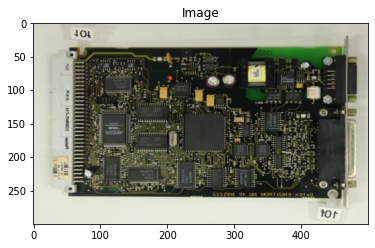

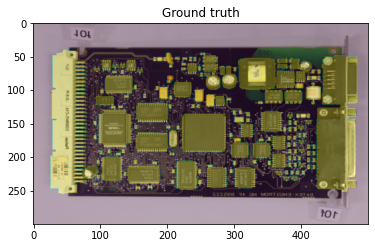

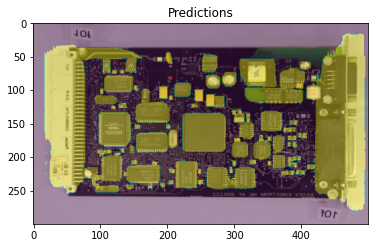

In [ ]:
analyze_train_sample(model, ds_train, 10)

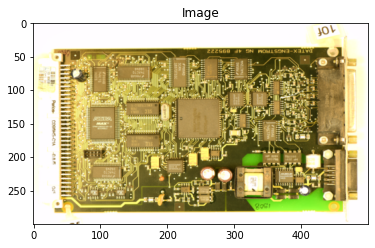

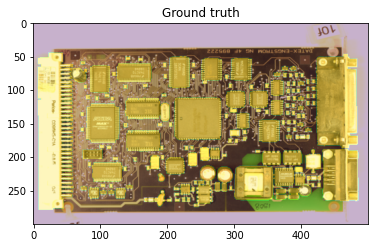

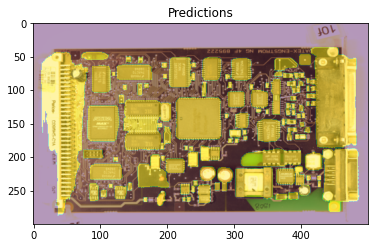

In [ ]:
analyze_train_sample(model, ds_train, 15)

ある程度予測はできているようですが、予測領域に無駄な部分が多いように見受けられます。epoch数を伸ばしたり、オーグメンテーションを変えることによって精度を伸ばせるかもしれません。

# テストデータの推論

モデルの学習が終了したので、最後にテストデータに対する推論を行います。なお、テストデータも画像サイズがかなり大きいため、リサイズしてから推論を行った後で、予測領域を実際の画像サイズに引き伸ばします。

In [ ]:
class SemiTestDataset(Dataset):
    def __init__(self, image_dir, df, transforms=None, resize = False):
        self.transforms = transforms
        self.image_dir = image_dir
        self.df = df
        self.image_ids = self.df["image"].values
        self.origin_height = self.df["height"].values
        self.origin_width = self.df["width"].values
        
        # リサイズ
        self.should_resize = resize is not False
        if self.should_resize:
            self.height = int(HEIGHT * resize)
            self.width = int(WIDTH * resize)
        else:
            self.height = HEIGHT
            self.width = WIDTH
    
    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image_path = os.path.join(self.image_dir, image_id)
        image = Image.open(image_path).convert("RGB")
        
        # 読み込んだ画像をリサイズ
        if self.should_resize:
            image = image.resize((self.width, self.height), resample=Image.BILINEAR)

        if self.transforms is not None:
            image, _ = self.transforms(image=image, target=None)
            
        # 大きさを戻すために元画像の大きさを取得
        origin_height = self.origin_height[idx]
        origin_width = self.origin_width[idx]
        
        return {'image': image, 'image_id': image_id, 'height': origin_height, 'width': origin_width, 'resize': self.should_resize}

    def __len__(self):
        return len(self.image_ids)

In [ ]:
ds_test = SemiTestDataset(TEST_PATH, test, transforms=get_transform(train=False), resize = True)

In [ ]:
def rle_encoding(x):
    dots = np.where(x.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return ' '.join(map(str, run_lengths))

# 重複したピクセルを除く
def remove_overlapping_pixels(mask, other_masks):
    for other_mask in other_masks:
        if np.sum(np.logical_and(mask, other_mask)) > 0:
            mask[np.logical_and(mask, other_mask)] = 0
    return mask

In [ ]:
# モデルの読み込み
model = get_model()
model.to(DEVICE)
model.load_state_dict(torch.load(str(OUTPUT/f"pytorch_model-e{NUM_EPOCHS}.bin")))

<All keys matched successfully>

In [ ]:
model.eval();

submission = []
for sample in tqdm(ds_test, total = ds_test.__len__()):
    img = sample['image']
    image_id = sample['image_id']
    origin_height = sample['height']
    origin_width = sample['width']
    resize = sample['resize']

    with torch.no_grad():
        result = model([img.to(DEVICE)])[0]
    
    previous_masks = []
    for i, mask in enumerate(result["masks"]):

        # スコアが低いものを除去
        score = result["scores"][i].cpu().item()
        if score < MIN_SCORE:
            continue
        
        mask = mask.cpu().numpy()
        
        if resize:
            mask = cv2.resize(mask[0], dsize = (origin_width, origin_height))
            mask = mask[np.newaxis, :, :]
        
        # 閾値処理
        binary_mask = mask > MASK_THRESHOLD
        binary_mask = remove_overlapping_pixels(binary_mask, previous_masks)
        previous_masks.append(binary_mask)
        rle = rle_encoding(binary_mask)
        submission.append((image_id, rle))
    
    # 予測結果がない時は空にしておく
    all_images_ids = [image_id for image_id, rle in submission]
    if image_id not in all_images_ids:
        submission.append((image_id, ""))

  0%|          | 0/28 [00:00<?, ?it/s]

In [ ]:
result

{'boxes': tensor([[223.1877, 184.8674, 244.1482, 197.5394],
         [ 94.0627, 111.2314, 169.5145, 194.1693],
         [268.4026, 158.2891, 305.9458, 182.2729],
         [180.1385, 205.1806, 269.8353, 258.5334],
         [352.5618, 177.9055, 362.6651, 185.0440],
         [220.4267, 163.4931, 225.4279, 169.7804],
         [344.8490, 177.9229, 349.4676, 184.7450],
         [247.1712, 141.8830, 253.1718, 150.2462],
         [324.9859, 140.1887, 330.4608, 147.1577],
         [337.6516, 239.0383, 349.8620, 247.3960],
         [350.4909, 197.6628, 363.4019, 207.9314],
         [318.2259, 169.6911, 329.7865, 179.4838],
         [326.3679, 180.9524, 330.5327, 187.0800],
         [183.1310, 160.2533, 188.3570, 166.1046],
         [219.3981, 162.7793, 227.0871, 171.1719],
         [207.0601, 192.9351, 212.7177, 197.5268],
         [188.3198, 192.8234, 194.2842, 197.8102],
         [181.7059, 159.1751, 189.5560, 167.9382],
         [309.5181, 237.4200, 316.8043, 242.6569],
         [197.3208, 11

In [ ]:
df_sub = pd.DataFrame(submission, columns=['image', 'predicted'])
df_sub

image                                          predicted
0     pcb_49f_cc_26.png  16906800 284 16907085 48 16913462 402 16920129...
1     pcb_49f_cc_26.png  22934778 175 22941441 204 22948111 221 2295478...
2     pcb_49f_cc_26.png  11277331 170 11283992 206 11290659 223 1129733...
3     pcb_49f_cc_26.png  22942199 173 22948859 202 22955525 220 2296219...
4     pcb_49f_cc_26.png  22846797 112 22853435 176 22860101 195 2286677...
...                 ...                                                ...
1743  pcb_46b_cc_23.png  4504698 19 4507871 27 4511047 26 4514222 27 45...
1744  pcb_46b_cc_23.png  3323904 12 3323925 5 3327074 38 3330249 40 333...
1745  pcb_46b_cc_23.png                                                   
1746  pcb_46b_cc_23.png  2799516 18 2802687 29 2805858 38 2809030 45 28...
1747  pcb_46b_cc_23.png  4985301 27 4988476 30 4991652 31 4994827 32 49...

[1748 rows x 2 columns]

In [ ]:
# submission書き出し
df_sub.to_csv(OUTPUT/"submission.csv", index = False)

最後に、テストデータの予測結果を確認してみましょう。

In [ ]:
# imageごとにまとめる
group_pred_df = pd.DataFrame(df_sub.groupby("image")["predicted"].apply(list).apply(' '.join))

In [ ]:
group_merged_df = pd.merge(group_pred_df, test, on = "image")
group_merged_df.head()

image                                          predicted  \
0   pcb_0f_cc_11.png  8648931 246 8653629 312 8658345 336 8663066 34...   
1  pcb_11f_cc_11.png  8832501 201 8836888 250 8841291 274 8845689 30...   
2  pcb_12f_cc_11.png  12102840 17 12107264 88 12111688 111 12116115 ...   
3  pcb_14f_cc_11.png  5051374 18 5058760 34 5058902 74 5066321 76 50...   
4  pcb_15f_cc_11.png  8792879 199 8793189 76 8798345 438 8803846 449...   

   height  width  
0    3030   4728  
1    3155   4420  
2    3671   4429  
3    1957   7566  
4    3783   5504

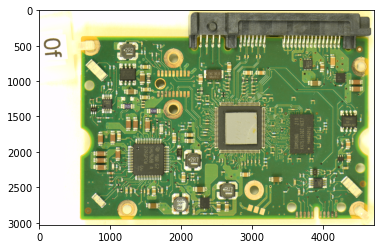

In [ ]:
sample_idx = 0
img = Image.open(os.path.join(TEST_PATH, group_merged_df["image"].values[sample_idx]))
plt.imshow(img)

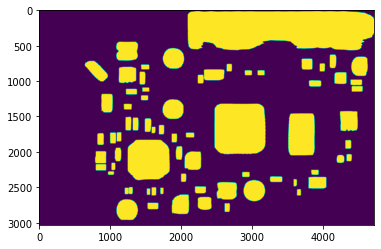

In [ ]:
rle = group_merged_df["predicted"].values[sample_idx]
height = group_merged_df["height"].values[sample_idx]
width = group_merged_df["width"].values[sample_idx]
sample_rle = rle_decode(rle, (height, width), color=1)
plt.imshow(sample_rle)

おおよそ予測ができているようですが、モデルの変更や前処理等でさらにスコアを伸ばせると考えられます。

これにて、チュートリアルコードは終了となります！

# 参考文献
- [1]He, Kaiming, et al. "Mask r-cnn." Proceedings of the IEEE international conference on computer vision. 2017.[https://arxiv.org/abs/1703.06870](https://arxiv.org/abs/1703.06870)
- [2][maskrcnn_resnet50_fpn](https://pytorch.org/vision/main/models/generated/torchvision.models.detection.maskrcnn_resnet50_fpn.html)